In [1]:
import os
os.environ["PYTHONWARNINGS"] = "ignore"

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import scanpy as sc
import squidpy as sq
import anndata
import pandas as pd
import numpy as np
import decoupler as dc
import gseapy as gp
import matplotlib.pyplot as plt

from libpysal.weights import KNN
from esda.moran import Moran
from skimage.draw import disk
from scipy.spatial import distance

In [4]:
sc.set_figure_params(dpi=100, facecolor=None, color_map="seismic", frameon=False, vector_friendly=True)
sc.settings._vector_friendly = False

In [5]:
# set working directory
project_dir = "/Users/cenkcelik/Cenk_scoring/"
working_dir = project_dir + ""
os.chdir(working_dir)

# set figure directory
figure_dir = working_dir + "figures/"

# processed data directory
processed_data = working_dir + "processed_data/"

In [6]:
# import a local package
import sys
sys.path.append("/Users/cenkcelik/Documents/GitHub/EnrichMap/")
import enrichmap as em

In [7]:
# Load human gene names from a reference file or database
def load_human_genes(n_genes=15000):
    gene_list = pd.read_csv("https://www.genenames.org/cgi-bin/download/custom?col=gd_app_sym&status=Approved&hgnc_dbtag=on&order_by=gd_app_sym&format=text", sep="\t")
    return np.random.choice(gene_list["Approved symbol"].values, n_genes, replace=False)

# Generate hexagonal grid for 10X Visium-like spatial coordinates
def generate_hexagonal_grid(rows=70, cols=70, spacing=50):
    x_coords, y_coords = [], []
    for row in range(rows):
        for col in range(cols):
            x = col * spacing + (row % 2) * (spacing / 2)
            y = row * spacing * np.sqrt(3) / 2
            x_coords.append(x)
            y_coords.append(y)
    return np.array(x_coords), np.array(y_coords)

# Assign biological labels in spatially coherent clusters
def assign_spatial_clusters(x_coords, y_coords, labels):
    num_spots = len(x_coords)
    label_assignment = np.random.choice(labels, num_spots, replace=True)
    
    for i in range(num_spots):
        nearest_neighbours = distance.cdist([(x_coords[i], y_coords[i])], np.column_stack((x_coords, y_coords))).flatten()
        close_spots = np.argsort(nearest_neighbours)[1:4]
        label_assignment[close_spots] = label_assignment[i] # Increase local clustering
    
    return label_assignment

# Simulate expression matrix
def generate_expression_matrix(n_spots, n_genes, labels, gene_signature):
    expression_matrix = np.random.poisson(5, (n_spots, n_genes))
    
    # Boost state gene expression in made up-labelled spots
    made_up_spots = np.where(labels == "cluster_2")[0]
    expression_matrix[made_up_spots[:, None], gene_signature] *= 5
    
    return expression_matrix

# generate a number between 0-255
def random_color():
    return np.random.randint(0, 256)

# Generate a dummy tissue image
def generate_tissue_image(image_size=(2000, 2000)):
    image = np.ones((*image_size, 3), dtype=np.uint8) * 252
    rr, cc = disk((500, 500), 300, shape=image.shape[:2])
    image[rr, cc] = [random_color(), random_color(), random_color()]
    return image

# Main function to generate simulated spatial AnnData
def generate_spatial_cancer_data(seed=0):
    np.random.seed(seed)
    n_genes = 15000
    x_coords, y_coords = generate_hexagonal_grid()
    n_spots = len(x_coords)
    gene_names = load_human_genes(n_genes)
    
    # Define labels
    labels = np.array(["cluster_1", "cluster_2", "cluster_3", "cluster_4"])
    assigned_labels = assign_spatial_clusters(x_coords, y_coords, labels)
    
    # Pick Made-up spots-related genes
    spot_gene_indices = np.random.choice(n_genes, size=100, replace=False)
    
    # Generate expression data
    expression_matrix = generate_expression_matrix(n_spots, n_genes, assigned_labels, spot_gene_indices)
    
    # Create AnnData object
    adata = anndata.AnnData(X=expression_matrix)
    adata.var_names = gene_names
    adata.obs["cluster"] = assigned_labels
    adata.obsm["spatial"] = np.column_stack((x_coords, y_coords))
    
    # Add Visium-like metadata
    adata.uns["spatial"] = {
        "image_1": {
            "images": {
                "hires": generate_tissue_image(),
                "lowres": generate_tissue_image((500, 500))
            },
            "metadata": {
                "chemistry_description": "Spatial 3' v1",
                "software_version": "spaceranger-1.2.2"
            },
            "scalefactors": {
                "fiducial_diameter_fullres": 28.89725002221966,
                "spot_diameter_fullres": 17.888773823278836,
                "tissue_hires_scalef": 0.856531,
                "tissue_lowres_scalef": 0.25695932
            }
        }
    }
    
    return adata

In [8]:
from anndata import AnnData
from typing import List
from scipy.spatial.distance import pdist
from skgstat import Variogram

def variogram(
    adata: AnnData,
    score_keys: List[str],
    save: None | str = None,
    max_lag: float | None = None,
    lag_percentile: float = 95
) -> List[Variogram]:
    coords = adata.obsm["spatial"]

    if max_lag is None:
        dists = pdist(coords)
        max_lag = np.percentile(dists, lag_percentile)

    variograms = []
    for key in score_keys:
        values = adata.obs[key].values
        V = Variogram(coords, values, method="cressie", model="gaussian", verbose=True)
        variograms.append(V)

    return variograms

In [9]:
# Define simulation parameters
n_simulations = 100
# generate list of random numbers
np.random.seed(0)
random_numbers = np.random.randint(0, 10000, n_simulations)
print(random_numbers[:10])

[2732 9845 3264 4859 9225 7891 4373 5874 6744 3468]


In [10]:
spatial_metrics = []
scores_summary = []
variogram_summary = []

In [11]:
for seed in random_numbers:
    print(f"Running simulation for seed: {seed}")

    adata = generate_spatial_cancer_data(seed=seed)
    adata.obs["cluster"] = pd.Categorical(adata.obs["cluster"])

    # Normalisation pipeline
    sc.pp.filter_genes(adata, min_cells=10)
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)

    # Identify marker genes
    sc.tl.rank_genes_groups(adata, groupby="cluster", method="t-test_overestim_var", use_raw=False)
    sc.tl.filter_rank_genes_groups(adata, min_in_group_fraction=0.5, min_fold_change=2, max_out_group_fraction=0.5)

    gene_set_10 = adata.uns["rank_genes_groups"]["names"]["cluster_2"][:10].tolist()
    signatures_dict = {"cluster_2": gene_set_10}
    signatures_df = pd.DataFrame(
        [(key, gene) for key, genes in signatures_dict.items() for gene in genes],
        columns=["geneset", "genesymbol"]
    )

    # Score using EnrichMap
    em.tl.score(adata, gene_set=gene_set_10, smoothing=True, correct_spatial_covariates=True)
    adata.obs["enrichmap_score"] = adata.obs["enrichmap_score"]

    # AUCell
    dc.run_aucell(adata, net=signatures_df, source="geneset", target="genesymbol", seed=seed, verbose=False, use_raw=False)
    acts = dc.get_acts(adata, obsm_key="aucell_estimate")
    adata.obs["aucell_score"] = acts.obsm["aucell_estimate"]["cluster_2"]

    # ssGSEA
    X_dense = adata.X.toarray() if not isinstance(adata.X, np.ndarray) else adata.X
    gene_expr = pd.DataFrame(X_dense.T, index=adata.var_names, columns=adata.obs_names)
    # gene_expr.index = gene_expr.index.str.upper()
    # signatures_dict = {k: [g.upper() for g in v] for k, v in signatures_dict.items()}
    ssgsea = gp.ssgsea(data=gene_expr, gene_sets=signatures_dict, outdir=None, sample_norm_method="rank", no_plot=True, min_size=5)
    nes = ssgsea.res2d.pivot(index="Term", columns="Name", values="NES")
    adata.obs["ssgsea_score"] = nes.loc["cluster_2"].T.astype(float).reindex(adata.obs_names)

    # GSVA
    gsva = gp.gsva(data=gene_expr,gene_sets=signatures_dict, outdir=None, min_size=5)
    es = gsva.res2d.pivot(index="Term", columns="Name", values="ES")
    adata.obs["gsva_score"] = es.loc["cluster_2"].T.astype(float).reindex(adata.obs_names)

    # z score
    z_score = gene_expr.loc[gene_set_10].sum(axis=0) / np.sqrt(len(gene_set_10))
    adata.obs["z_score"] = z_score

    # Scanpy AddModuleScore
    sc.tl.score_genes(adata, gene_set_10, score_name="scanpy_score", use_raw=False)

    # Moran's I for each score
    for score in ["enrichmap_score", "aucell_score", "scanpy_score", "ssgsea_score", "gsva_score", "z_score"]:
        sq.gr.spatial_neighbors(adata, n_neighs=6, coord_type="generic", key_added="spatial")
        # Extract spatial weights from coordinates
        W = KNN.from_array(adata.obsm["spatial"])
        W.transform = "r"
        score_vec = adata.obs[score].values.astype(np.float64)
        moran = Moran(score_vec, W)
        I = moran.I
        spatial_metrics.append({"seed": seed, "method": score, "moran_I": I})

        # Compute variogram
        V = variogram(adata, score_keys=[score])[0]
        for bin_edge, gamma in zip(V.bins, V.experimental):
            variogram_summary.append({
                "seed": seed,
                "method": score,
                "distance": bin_edge,
                "semivariance": gamma
            })

    # Store scores
    scores_summary.append(
        pd.DataFrame({
            "seed": seed,
            "enrichmap": adata.obs["enrichmap_score"],
            "aucell": adata.obs["aucell_score"],
            "scanpy": adata.obs["scanpy_score"],
            "ssgsea": adata.obs["ssgsea_score"],
            "gsva": adata.obs["gsva_score"],
            "z_score": adata.obs["z_score"]
        })
    )


Running simulation for seed: 2732


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  6.34it/s]


Running simulation for seed: 9845


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  7.37it/s]


Running simulation for seed: 3264


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  7.27it/s]


Running simulation for seed: 4859


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  7.46it/s]


Running simulation for seed: 9225


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  6.63it/s]


Running simulation for seed: 7891


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  6.89it/s]


Running simulation for seed: 4373


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  7.54it/s]


Running simulation for seed: 5874


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  5.32it/s]


Running simulation for seed: 6744


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  5.18it/s]


Running simulation for seed: 3468


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  7.45it/s]


Running simulation for seed: 705


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  7.32it/s]


Running simulation for seed: 2599


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  6.82it/s]


Running simulation for seed: 2222


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  6.23it/s]


Running simulation for seed: 7768


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  7.48it/s]


Running simulation for seed: 2897


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  7.39it/s]


Running simulation for seed: 9893


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  7.65it/s]


Running simulation for seed: 537


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  7.04it/s]


Running simulation for seed: 6216


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  7.84it/s]


Running simulation for seed: 6921


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  7.69it/s]


Running simulation for seed: 6036


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  7.64it/s]


Running simulation for seed: 2163


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  7.37it/s]


Running simulation for seed: 5072


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  7.30it/s]


Running simulation for seed: 4851


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  7.79it/s]


Running simulation for seed: 7877


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  7.56it/s]


Running simulation for seed: 2046


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  7.10it/s]


Running simulation for seed: 1871


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  7.60it/s]


Running simulation for seed: 7599


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  6.72it/s]


Running simulation for seed: 2496


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  7.32it/s]


Running simulation for seed: 8291


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  7.68it/s]


Running simulation for seed: 755


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  7.43it/s]


Running simulation for seed: 797


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  7.73it/s]


Running simulation for seed: 659


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  7.29it/s]


Running simulation for seed: 3219


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  7.46it/s]


Running simulation for seed: 8615


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  5.41it/s]


Running simulation for seed: 7456


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  7.78it/s]


Running simulation for seed: 3337


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  7.58it/s]


Running simulation for seed: 2745


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  7.41it/s]


Running simulation for seed: 4735


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  7.20it/s]


Running simulation for seed: 8736


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  7.13it/s]


Running simulation for seed: 6687


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  7.26it/s]


Running simulation for seed: 714


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  6.85it/s]


Running simulation for seed: 2292


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  7.15it/s]


Running simulation for seed: 8343


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  7.38it/s]


Running simulation for seed: 1207


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  7.05it/s]


Running simulation for seed: 6172


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  7.59it/s]


Running simulation for seed: 8994


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  7.30it/s]


Running simulation for seed: 7221


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  7.69it/s]


Running simulation for seed: 6021


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  7.51it/s]


Running simulation for seed: 3622


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  7.54it/s]


Running simulation for seed: 3560


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  7.13it/s]


Running simulation for seed: 8948


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


Running simulation for seed: 1641


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  7.60it/s]


Running simulation for seed: 4984


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  7.16it/s]


Running simulation for seed: 4353


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  7.21it/s]


Running simulation for seed: 8622


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  7.83it/s]


Running simulation for seed: 7250


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  7.38it/s]


Running simulation for seed: 4187


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  7.20it/s]


Running simulation for seed: 2659


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  7.21it/s]


Running simulation for seed: 9781


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  7.41it/s]


Running simulation for seed: 2956


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  7.24it/s]


Running simulation for seed: 2251


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  7.44it/s]


Running simulation for seed: 4420


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  7.12it/s]


Running simulation for seed: 7108


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  7.39it/s]


Running simulation for seed: 1071


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  7.13it/s]


Running simulation for seed: 5251


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  7.83it/s]


Running simulation for seed: 7012


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  7.01it/s]


Running simulation for seed: 9396


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  7.43it/s]


Running simulation for seed: 3918


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  7.44it/s]


Running simulation for seed: 9359


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  6.76it/s]


Running simulation for seed: 1684


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  7.21it/s]


Running simulation for seed: 7098


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  7.53it/s]


Running simulation for seed: 2957


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  7.29it/s]


Running simulation for seed: 4469


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  7.16it/s]


Running simulation for seed: 8752


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  8.18it/s]


Running simulation for seed: 9797


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  7.48it/s]


Running simulation for seed: 5795


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  7.31it/s]


Running simulation for seed: 1472


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  7.52it/s]


Running simulation for seed: 7263


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  7.11it/s]


Running simulation for seed: 7365


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  7.13it/s]


Running simulation for seed: 8448


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  7.52it/s]


Running simulation for seed: 6001


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  6.98it/s]


Running simulation for seed: 3762


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  7.33it/s]


Running simulation for seed: 9008


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  7.12it/s]


Running simulation for seed: 2435


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  7.44it/s]


Running simulation for seed: 1634


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  7.11it/s]


Running simulation for seed: 973


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  7.42it/s]


Running simulation for seed: 4464


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  7.11it/s]


Running simulation for seed: 8393


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  7.66it/s]


Running simulation for seed: 2418


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  7.64it/s]


Running simulation for seed: 3455


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  6.99it/s]


Running simulation for seed: 6167


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  5.39it/s]


Running simulation for seed: 5819


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  7.02it/s]


Running simulation for seed: 6521


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  7.43it/s]


Running simulation for seed: 6242


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  7.45it/s]


Running simulation for seed: 7742


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  7.75it/s]


Running simulation for seed: 9123


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  7.33it/s]


Running simulation for seed: 6738


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  7.89it/s]


Running simulation for seed: 2787


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  6.75it/s]


Running simulation for seed: 7316


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  7.07it/s]


Running simulation for seed: 4305


Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  6.27it/s]


In [12]:
# Combine results
metrics_df = pd.DataFrame(spatial_metrics)
scores_df = pd.concat(scores_summary)
variogram_df = pd.DataFrame(variogram_summary)

<Figure size 400x600 with 0 Axes>

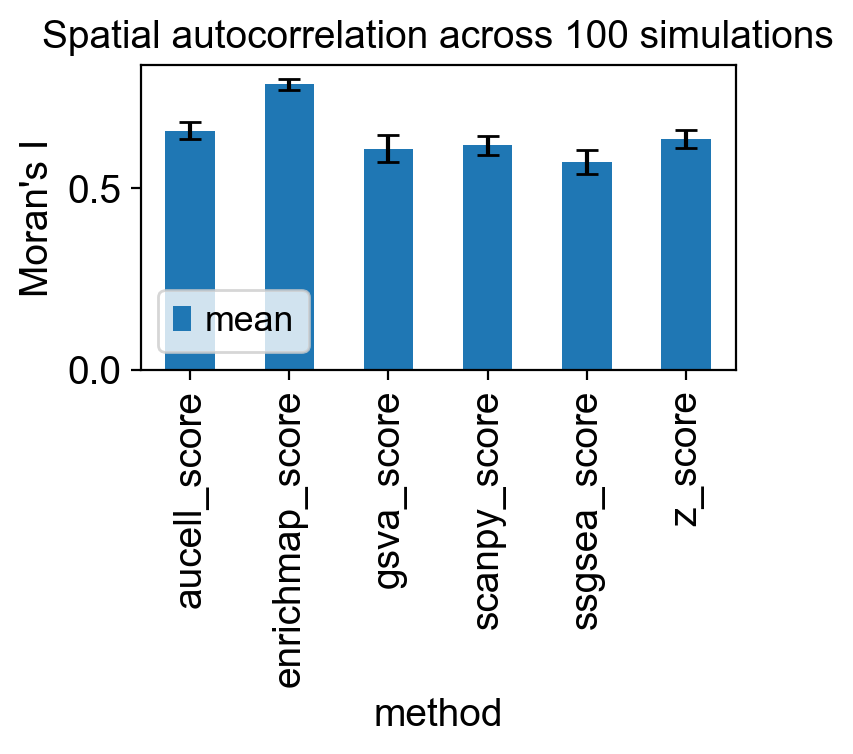

In [13]:
# Plot Moran's I with error bars
plt.figure(figsize=(4, 6))
metrics_df.groupby("method")["moran_I"].agg(["mean", "std"]).plot.bar(y="mean", yerr="std", capsize=4)
plt.ylabel("Moran's I")
plt.title("Spatial autocorrelation across 100 simulations")
plt.tight_layout()
plt.grid(False)
plt.savefig(figure_dir + "moranI_across_simulations.pdf")
plt.show()

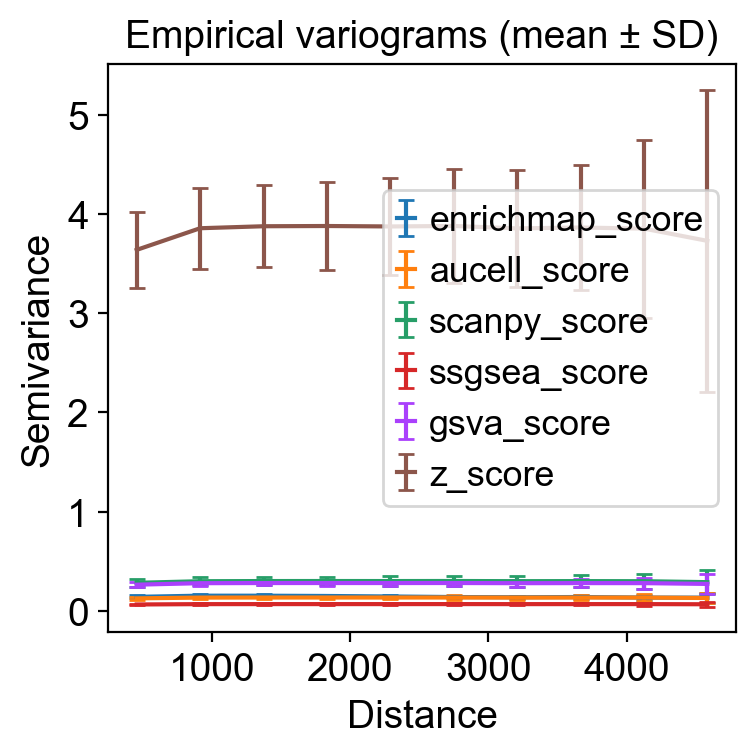

In [14]:
# Plot average variogram
plt.figure(figsize=(4, 4))
for method in ["enrichmap_score", "aucell_score", "scanpy_score", "ssgsea_score", "gsva_score", "z_score"]:
    df = variogram_df[variogram_df["method"] == method]
    grouped = df.groupby("distance")["semivariance"].agg(["mean", "std"])
    plt.errorbar(grouped.index, grouped["mean"], yerr=grouped["std"], label=method, capsize=3)

plt.xlabel("Distance")
plt.ylabel("Semivariance")
plt.title("Empirical variograms (mean ± SD)")
plt.legend()
plt.tight_layout()
plt.grid(False)
plt.savefig(figure_dir + "variograms_across_simulations.pdf")
plt.show()

In [15]:
# Optionally, save metrics to CSV
metrics_df.to_csv(os.path.join(figure_dir, "spatial_metrics.csv"), index=False)
scores_df.to_csv(os.path.join(figure_dir, "scores_summary.csv"), index=False)
variogram_df.to_csv(os.path.join(figure_dir, "variogram_summary.csv"), index=False)

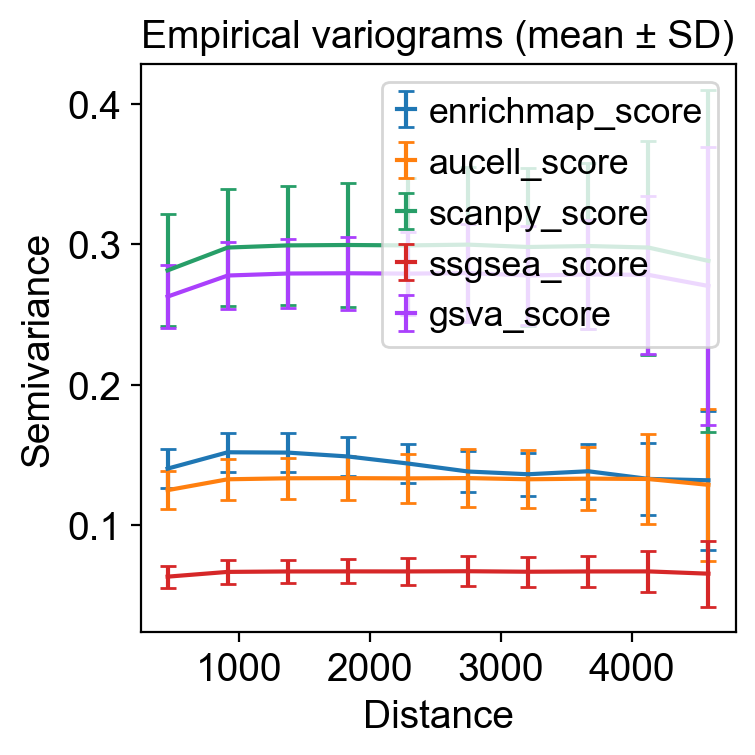

In [16]:
# Plot average variogram
plt.figure(figsize=(4, 4))
for method in ["enrichmap_score", "aucell_score", "scanpy_score", "ssgsea_score", "gsva_score"]:
    df = variogram_df[variogram_df["method"] == method]
    grouped = df.groupby("distance")["semivariance"].agg(["mean", "std"])
    plt.errorbar(grouped.index, grouped["mean"], yerr=grouped["std"], label=method, capsize=3)

plt.xlabel("Distance")
plt.ylabel("Semivariance")
plt.title("Empirical variograms (mean ± SD)")
plt.legend()
plt.tight_layout()
plt.grid(False)
plt.savefig(figure_dir + "variograms_across_simulations_except.pdf")
plt.show()